In [342]:
%matplotlib notebook
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from data_generator_boneage import BoneAgeDataset
from models import BreastPathQModel
from uce import uceloss
from calibration_plots import plot_uncert, plot_frequency
from utils import nll_criterion_gaussian
from glob import glob
from test import AuxModel, train_aux
%matplotlib notebook

In [343]:
base_model = 'densenet201'

In [344]:
assert base_model in ['resnet101', 'densenet201', 'efficientnetb4']
device = torch.device("cuda:0")
resize_to = (256, 256)

In [345]:
batch_size = 16

data_set = BoneAgeDataset(data_dir='/media/fastdata/laves/rsna-bone-age/', augment=False, resize_to=resize_to)
assert len(data_set) > 0

calib_indices = torch.load('./boneage_valid_indices.pth')
test_indices = torch.load('./boneage_test_indices.pth')

print(calib_indices.shape)
print(test_indices.shape)

calib_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(calib_indices))
test_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                          sampler=SubsetRandomSampler(test_indices))

torch.Size([2000])
torch.Size([4000])


In [346]:
model = BreastPathQModel(base_model, in_channels=1, out_channels=1).to(device)

checkpoint_path = glob(f"/media/fastdata/laves/regression_snapshots/{base_model}_gaussian_boneage_2.pth.tar")[0]

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])
print("Loading previous weights at epoch " + str(checkpoint['epoch']))

Loading previous weights at epoch 485


In [347]:
model.eval()
mus_calib = []
vars_calib = []
logvars_calib = []
targets_calib = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(calib_loader)):
        data, target = data.to(device), target.to(device)

        mu, logvar, var_bayesian = model(data, dropout=True, mc_dropout=True)

        mus_calib.append(mu.detach())
        vars_calib.append(var_bayesian.detach())
        logvars_calib.append(logvar.detach())
        targets_calib.append(target.detach())

mu_calib = torch.cat(mus_calib, dim=0)
var_calib = torch.cat(vars_calib, dim=0)
logvar_calib = torch.cat(logvars_calib, dim=0)
target_calib = torch.cat(targets_calib, dim=0)

print("l1 =", torch.nn.functional.l1_loss(mu_calib, target_calib).item())



  0%|          | 0/125 [00:00<?, ?it/s]

  1%|          | 1/125 [00:01<03:02,  1.48s/it]

  2%|▏         | 2/125 [00:02<02:58,  1.45s/it]

  2%|▏         | 3/125 [00:04<02:55,  1.44s/it]

  3%|▎         | 4/125 [00:05<02:53,  1.43s/it]

  4%|▍         | 5/125 [00:07<02:53,  1.44s/it]

  5%|▍         | 6/125 [00:08<02:52,  1.45s/it]

  6%|▌         | 7/125 [00:10<02:49,  1.44s/it]

  6%|▋         | 8/125 [00:11<02:45,  1.42s/it]

  7%|▋         | 9/125 [00:12<02:47,  1.44s/it]

  8%|▊         | 10/125 [00:14<02:43,  1.42s/it]

  9%|▉         | 11/125 [00:15<02:44,  1.44s/it]

 10%|▉         | 12/125 [00:17<02:45,  1.46s/it]

 10%|█         | 13/125 [00:18<02:43,  1.46s/it]

 11%|█         | 14/125 [00:20<02:39,  1.43s/it]

 12%|█▏        | 15/125 [00:21<02:36,  1.42s/it]

 13%|█▎        | 16/125 [00:22<02:34,  1.42s/it]

 14%|█▎        | 17/125 [00:24<02:33,  1.42s/it]

 14%|█▍        | 18/125 [00:25<02:30,  1.41s/it]

 15%|█▌        | 19/125 [00:27<02:29,  1.41s/it]

 16%|█▌        |

l1 = 0.04521071910858154


In [348]:
err_calib = torch.pow(target_calib-mu_calib, 2).mean(dim=1, keepdim=True).sqrt()

uncertainty = 'total'

uncert_calib_aleatoric = logvar_calib.exp()
uncert_calib_epistemic = var_calib

if uncertainty == 'aleatoric':
    uncert_calib = uncert_calib_aleatoric.sqrt()
elif uncertainty == 'epistemic':
    uncert_calib = uncert_calib_epistemic.sqrt()
else:
    uncert_calib = (uncert_calib_aleatoric + uncert_calib_epistemic).sqrt().clamp(0, 1)  # total

In [349]:
print(err_calib.mean())
print((uncert_calib**2).mean())
print(uncert_calib_aleatoric.mean())
print(uncert_calib_epistemic.mean())

tensor(0.0452, device='cuda:0')
tensor(0.0031, device='cuda:0')
tensor(0.0027, device='cuda:0')
tensor(0.0004, device='cuda:0')


<IPython.core.display.Javascript object>


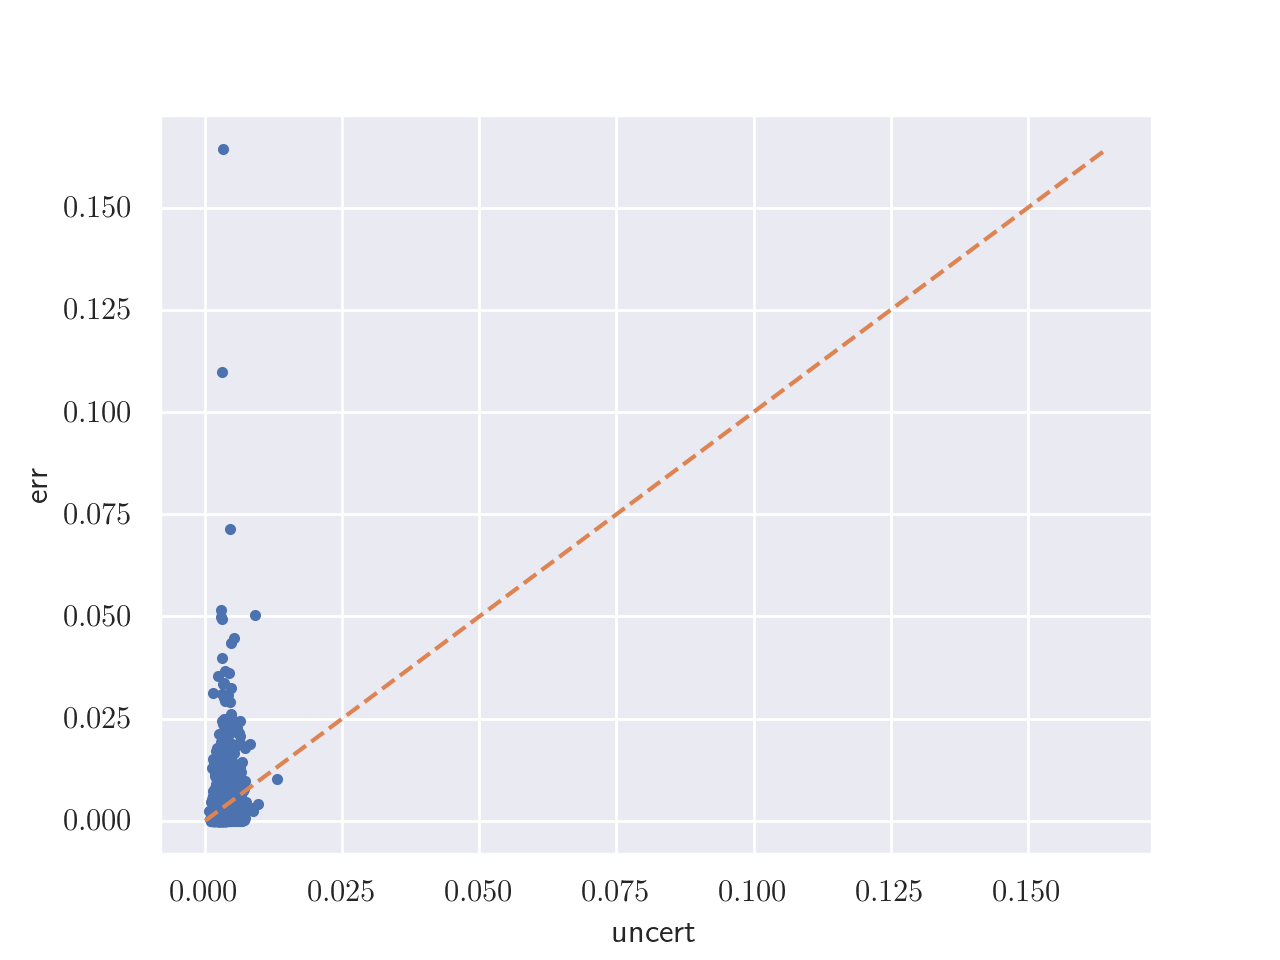

In [350]:
fig, ax = plt.subplots(1)
ax.plot(uncert_calib.cpu()**2, err_calib.cpu()[:,0]**2, '.')

max_val = max((err_calib**2).max().item(), (uncert_calib**2).max().item())
ax.plot([0, max_val], [0, max_val], '--')
ax.set_xlabel('uncert')
ax.set_ylabel('err')
plt.show()

In [351]:
# calculate optimal T
S = (err_calib**2 / uncert_calib**2).mean().sqrt()
print(S)

tensor(1.0555, device='cuda:0')


In [352]:
class Scaler(torch.nn.Module):
    def __init__(self, init_S=1.0):
        super().__init__()
        self.S = torch.nn.Parameter(torch.tensor([init_S]))

    def forward(self, x):
        return self.S.mul(x)

In [353]:
# find optimal S
scaler = Scaler(init_S=S).to(device)
s_opt = torch.optim.LBFGS([scaler.S], lr=3e-2, max_iter=2000)

def closure():
    s_opt.zero_grad()

    loss = nll_criterion_gaussian(mu_calib, scaler(uncert_calib).pow(2).log(), target_calib)

    loss.backward()
    return loss

s_opt.step(closure)
print(scaler.S.item())

1.0554890632629395


In [354]:
aux = AuxModel(1).to(device)
loss = train_aux(aux, nll_criterion_gaussian, mu_calib, uncert_calib, target_calib)
print(loss)

-4.727426052093506


In [355]:
aux.train()
print(nll_criterion_gaussian(mu_calib, uncert_calib.pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, (S*uncert_calib).pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, scaler(uncert_calib).pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, aux(uncert_calib), target_calib).item())
aux.eval()

-4.723649501800537
-4.729698657989502
-4.729698657989502
-4.727426528930664


AuxModel(
  (linear1): Linear(in_features=1, out_features=16, bias=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [356]:
print(torch.nn.functional.mse_loss(uncert_calib**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss((S*uncert_calib)**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(scaler(uncert_calib)**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(aux(uncert_calib)**2, err_calib**2, reduction='sum').item())

0.0984083041548729
0.09807419776916504
0.09807419776916504
0.09814746677875519


<IPython.core.display.Javascript object>


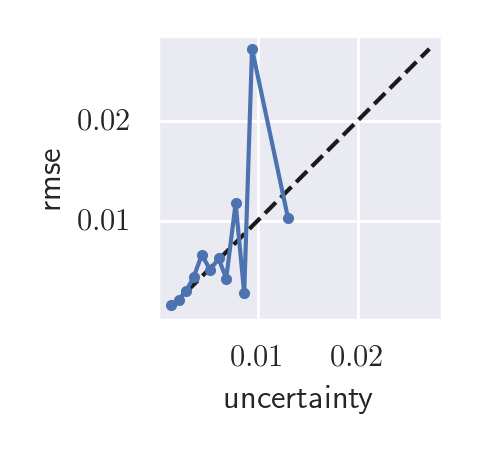

tensor([0.0005], device='cuda:0')


In [357]:
uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(err_calib**2, uncert_calib**2)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce)
plt.show()

<IPython.core.display.Javascript object>


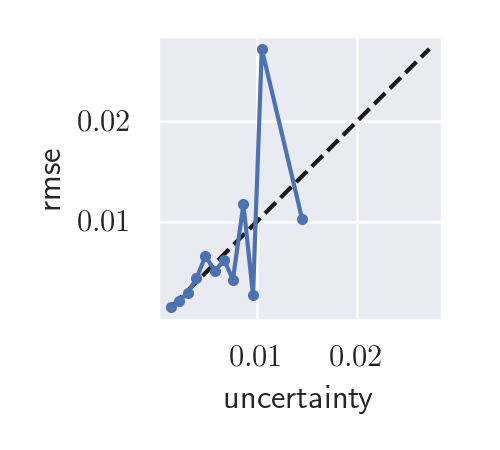

0.00044177877134643495


In [358]:
uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(err_calib**2, (S*uncert_calib)**2)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce.item())
plt.show()

<IPython.core.display.Javascript object>


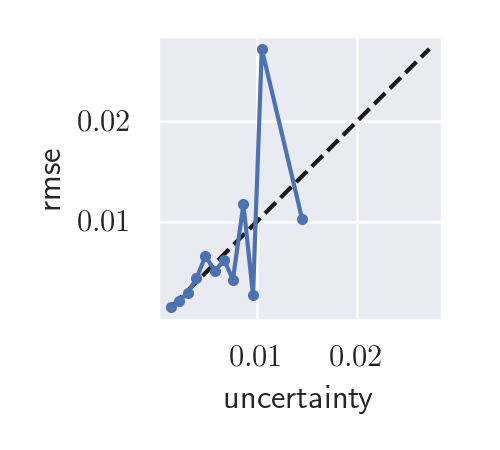

0.00044177877134643495


In [359]:
uce, err_in_bin, avg_uncert_in_bin, freq_in_bin = uceloss(err_calib**2, scaler(uncert_calib)**2)
plot_uncert(err_in_bin.cpu(), avg_uncert_in_bin.cpu())
plt.show()
print(uce.item())
#fig, ax = plot_frequency(scaler(uncert_calib).cpu(), freq_in_bin.cpu())
#fig.show()

<IPython.core.display.Javascript object>


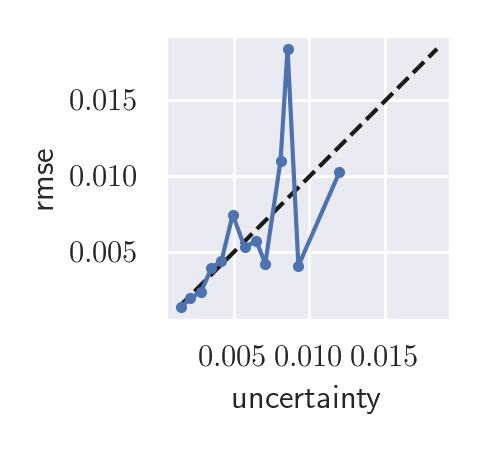

0.00048391291056759655


In [360]:
uce, err_in_bin, avg_uncert_in_bin, freq_in_bin = uceloss(err_calib**2, aux(uncert_calib)**2)
plot_uncert(err_in_bin.cpu(), avg_uncert_in_bin.cpu())
plt.show()
print(uce.item())

In [361]:
mus_test = []
vars_test = []
logvars_test = []
targets_test = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
        data, target = data.to(device), target.to(device)

        mu, logvar, var_bayesian = model(data, dropout=True, mc_dropout=True)

        mus_test.append(mu.detach())
        vars_test.append(var_bayesian.detach())
        logvars_test.append(logvar.detach())
        targets_test.append(target.detach())

mu_test_s = torch.cat(mus_test, dim=0).clamp(0, 1)
var_test_s = torch.cat(vars_test, dim=0)
logvar_test_s = torch.cat(logvars_test, dim=0)
target_test_s = torch.cat(targets_test, dim=0)



  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 1/250 [00:01<06:15,  1.51s/it]

  1%|          | 2/250 [00:02<06:09,  1.49s/it]

  1%|          | 3/250 [00:04<06:02,  1.47s/it]

  2%|▏         | 4/250 [00:05<05:59,  1.46s/it]

  2%|▏         | 5/250 [00:07<05:57,  1.46s/it]

  2%|▏         | 6/250 [00:08<05:51,  1.44s/it]

  3%|▎         | 7/250 [00:10<05:48,  1.43s/it]

  3%|▎         | 8/250 [00:11<05:46,  1.43s/it]

  4%|▎         | 9/250 [00:12<05:41,  1.42s/it]

  4%|▍         | 10/250 [00:14<05:43,  1.43s/it]

  4%|▍         | 11/250 [00:15<05:40,  1.42s/it]

  5%|▍         | 12/250 [00:17<05:40,  1.43s/it]

  5%|▌         | 13/250 [00:18<05:41,  1.44s/it]

  6%|▌         | 14/250 [00:20<05:40,  1.44s/it]

  6%|▌         | 15/250 [00:21<05:39,  1.45s/it]

  6%|▋         | 16/250 [00:23<05:37,  1.44s/it]

  7%|▋         | 17/250 [00:24<05:37,  1.45s/it]

  7%|▋         | 18/250 [00:25<05:36,  1.45s/it]

  8%|▊         | 19/250 [00:27<05:32,  1.44s/it]

  8%|▊         |

In [362]:
err_test_s = torch.pow(target_test_s-mu_test_s, 2).sqrt()

uncert_aleatoric_test = logvar_test_s.exp()
uncert_epistemic_test = var_test_s

if uncertainty == 'aleatoric':
    uncert_test = uncert_aleatoric_test.sqrt().clamp(0, 1)
elif uncertainty == 'epistemic':
    uncert_test = uncert_epistemic_test.sqrt().clamp(0, 1)
else:
    uncert_test_s = (uncert_aleatoric_test + uncert_epistemic_test).sqrt().clamp(0, 1)  # total

In [363]:
print(err_test_s.mean())
print(uncert_test_s.mean())

tensor(0.0456, device='cuda:0')
tensor(0.0548, device='cuda:0')


In [364]:
aux.train()
print(nll_criterion_gaussian(mu_test_s, uncert_test_s.pow(2).log(), target_test_s).item())
print(nll_criterion_gaussian(mu_test_s, (S*uncert_test_s).pow(2).log(), target_test_s).item())
print(nll_criterion_gaussian(mu_test_s, scaler(uncert_test_s).pow(2).log(), target_test_s).item())
print(nll_criterion_gaussian(mu_test_s, aux(uncert_test_s), target_test_s).item())
aux.eval()

-4.756929874420166
-4.760023593902588
-4.760023593902588
-4.754873275756836


AuxModel(
  (linear1): Linear(in_features=1, out_features=16, bias=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [365]:
print(torch.nn.functional.mse_loss(uncert_test_s**2, err_test_s**2, reduction='sum').item())
print(torch.nn.functional.mse_loss((S*uncert_test_s)**2, err_test_s**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(scaler(uncert_test_s)**2, err_test_s**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(aux(uncert_test_s)**2, err_test_s**2, reduction='sum').item())

0.18500766158103943
0.18381474912166595
0.18381474912166595
0.18494729697704315


<IPython.core.display.Javascript object>


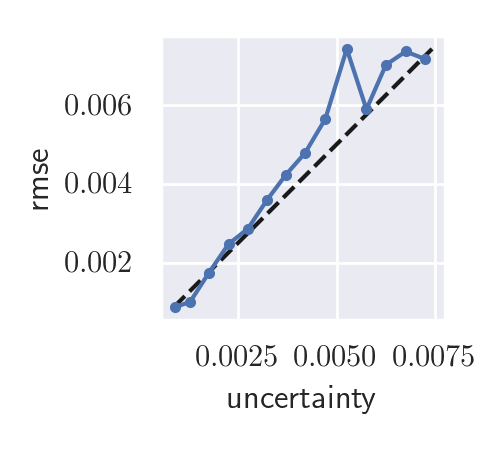

0.0004192369233351201


In [366]:
n_bins = 15
uce_uncal, _, _, _ = uceloss(err_test_s**2, uncert_test_s**2, n_bins=n_bins)
_, err_uncal, sigma_uncal, _ = uceloss(err_test_s**2, uncert_test_s**2, n_bins=n_bins, range=[0.0, 0.0075])
plot_uncert(err_uncal.cpu(), sigma_uncal.cpu())
print(uce_uncal.item())

<IPython.core.display.Javascript object>


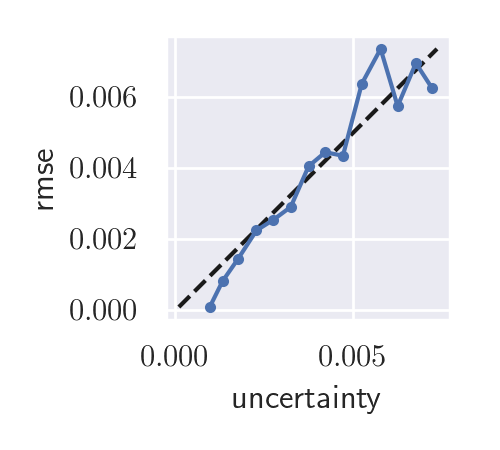

0.0003464420442469418


In [367]:
uce, _, _, _ = uceloss(err_test**2, (S*uncert_test)**2, n_bins=n_bins)
_, err_in_bin, avg_sigma_in_bin, _ = uceloss(err_test**2, (S*uncert_test)**2, n_bins=n_bins, range=[0.0, 0.0075])
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce.item())

<IPython.core.display.Javascript object>


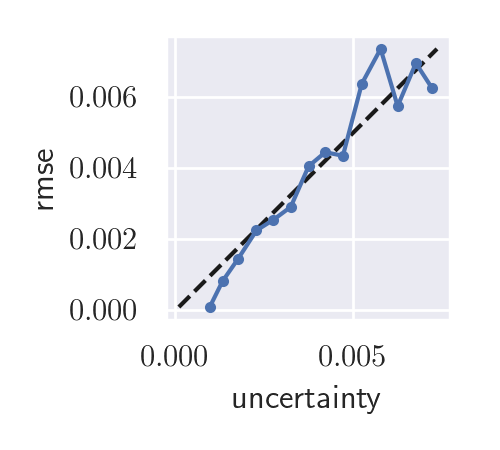

0.0003464420442469418


<IPython.core.display.Javascript object>


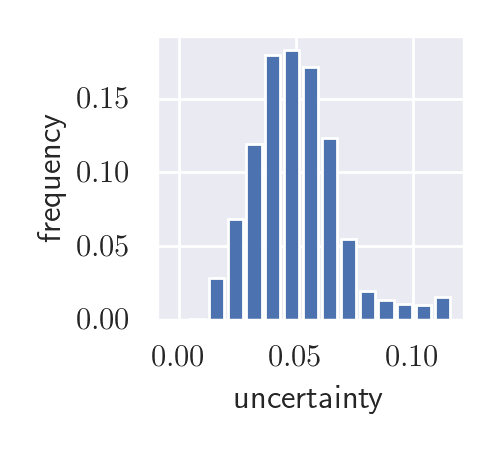

In [368]:
uce_cal, _, _, _ = uceloss(err_test**2, scaler(uncert_test)**2, n_bins=n_bins)
_, err_cal, sigma_cal, in_bin = uceloss(err_test**2, scaler(uncert_test)**2, n_bins=n_bins, range=[0.0, 0.0075])
plot_uncert(err_cal.cpu(), sigma_cal.cpu())
plt.show()
print(uce_cal.item())
fig, ax = plot_frequency(scaler(uncert_test).cpu(), in_bin.cpu(), n_bins=n_bins)
fig.show()

<IPython.core.display.Javascript object>


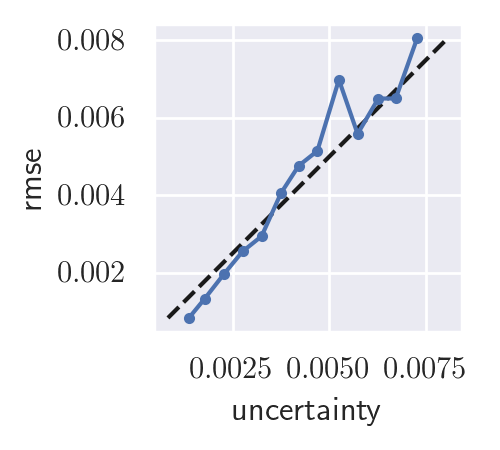

0.00040252855978906155


In [371]:
uce_aux, _, _, _ = uceloss(err_test**2, aux(uncert_test)**2, n_bins=n_bins)
_, err_aux, sigma_aux, freq_in_bin = uceloss(err_test**2, aux(uncert_test)**2, n_bins=n_bins, range=[0.0, 0.0075])
plot_uncert(err_aux.cpu(), sigma_aux.cpu())
plt.show()
print(uce_aux.item())

# Unreliable Predictions

The subsequent figure shows the mean MSE after rejecting all predictions, where uncert > uncert_max. The shadow width visualizes the percentage of rejected samples. On the very right side of the plot, the width represents 100 % of the test set samples.

In [372]:
import seaborn as sns

sns.set()
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{bm}']

In [414]:
e_s_list = []
u_s_list = []
t_s_list = []
num_rejected_s = []
uncert_s = scaler(uncert_test)**2

for thresh in np.linspace(uncert_s.max().item(), uncert_s.min().item(), 100)[:-1]:
    e = (err_test**2)[torch.where(uncert_s < thresh)]
    u = uncert_s[torch.where(uncert_s < thresh)]

    t_s_list.append(thresh)
    e_s_list.append(e.mean().item())
    u_s_list.append(u.mean().item())
    num_rejected_s.append((err_test.shape[0]-e.shape[0])/err_test.shape[0])

t_s_list = np.array(t_s_list)
e_s_list = np.array(e_s_list)
u_s_list = np.array(u_s_list)
num_rejected_s = np.array(num_rejected_s)

<IPython.core.display.Javascript object>


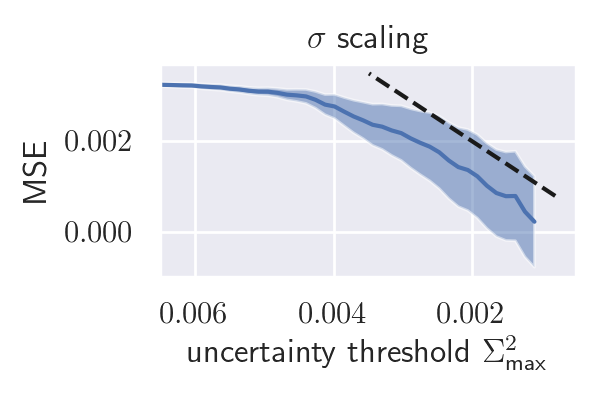

In [419]:
fig, ax = plt.subplots(1, figsize=(3.0, 2.0))

ax.plot([0.0008, e_s_list.max()], [0.0008, e_s_list.max()], 'k--')
ax.plot(t_s_list, e_s_list)
ax.fill_between(t_s_list, e_s_list-num_rejected_s/1000, e_s_list+num_rejected_s/1000, alpha=0.5)
ax.set_xlim(
    #ax[0].get_xlim()[1],
    0.0065,
    0.0005)
ax.set_xlabel(r'uncertainty threshold $ \Sigma^2_{\mathsf{max}} $')
ax.set_ylabel(r'MSE')
ax.set_title(r'$ \sigma $ scaling')

fig.tight_layout()
fig.show()
fig.savefig(f"rejection_s_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)

# OOD Detection

In [210]:
mus_ood = []
uncerts_ood = []
errs_ood = []
repetitions = 1

with torch.no_grad():
    for s in [0.0, 0.1, 0.2]:
        mu_ood = []
        uncert_ood = []
        err_ood = []
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
                data, target = data.to(device), target.to(device)
                img = data + torch.randn_like(data)*s + s
                mu, logvar, var_bayesian = model(img, dropout=True, mc_dropout=True)

                err = torch.pow(target-mu, 2)#.sqrt()
                uncert_aleatoric_test = logvar.exp()
                uncert_epistemic_test = var_bayesian

                mu_ood.append(mu.cpu().squeeze().numpy())
                uncert = (uncert_aleatoric_test + uncert_epistemic_test).clamp(0, 1)
                uncert_ood.append(uncert.cpu().squeeze().numpy())
                err_ood.append(err.cpu().squeeze().numpy())

        mus_ood.append(mu_ood)
        uncerts_ood.append(uncert_ood)
        errs_ood.append(err_ood)



  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 1/250 [00:01<07:56,  1.91s/it]

  1%|          | 2/250 [00:03<07:24,  1.79s/it]

  1%|          | 3/250 [00:05<07:10,  1.74s/it]

  2%|▏         | 4/250 [00:06<06:54,  1.69s/it]

  2%|▏         | 5/250 [00:08<06:44,  1.65s/it]

  2%|▏         | 6/250 [00:09<06:36,  1.62s/it]

  3%|▎         | 7/250 [00:11<06:30,  1.61s/it]

  3%|▎         | 8/250 [00:12<06:27,  1.60s/it]

  4%|▎         | 9/250 [00:14<06:28,  1.61s/it]

  4%|▍         | 10/250 [00:16<06:23,  1.60s/it]

  4%|▍         | 11/250 [00:17<06:19,  1.59s/it]

  5%|▍         | 12/250 [00:19<06:23,  1.61s/it]

  5%|▌         | 13/250 [00:20<06:15,  1.58s/it]

  6%|▌         | 14/250 [00:22<06:12,  1.58s/it]

  6%|▌         | 15/250 [00:23<06:08,  1.57s/it]

  6%|▋         | 16/250 [00:25<06:04,  1.56s/it]

  7%|▋         | 17/250 [00:27<06:01,  1.55s/it]

  7%|▋         | 18/250 [00:28<06:01,  1.56s/it]

  8%|▊         | 19/250 [00:30<05:58,  1.55s/it]

  8%|▊         |

 15%|█▌        | 38/250 [00:55<05:07,  1.45s/it]

 16%|█▌        | 39/250 [00:57<05:04,  1.44s/it]

 16%|█▌        | 40/250 [00:58<05:02,  1.44s/it]

 16%|█▋        | 41/250 [01:00<04:59,  1.43s/it]

 17%|█▋        | 42/250 [01:01<05:00,  1.45s/it]

 17%|█▋        | 43/250 [01:02<04:59,  1.45s/it]

 18%|█▊        | 44/250 [01:04<04:59,  1.45s/it]

 18%|█▊        | 45/250 [01:05<04:54,  1.44s/it]

 18%|█▊        | 46/250 [01:07<04:57,  1.46s/it]

 19%|█▉        | 47/250 [01:08<04:55,  1.45s/it]

 19%|█▉        | 48/250 [01:10<04:53,  1.45s/it]

 20%|█▉        | 49/250 [01:11<04:50,  1.44s/it]

 20%|██        | 50/250 [01:13<04:51,  1.46s/it]

 20%|██        | 51/250 [01:14<04:49,  1.46s/it]

 21%|██        | 52/250 [01:16<04:50,  1.47s/it]

 21%|██        | 53/250 [01:17<04:52,  1.48s/it]

 22%|██▏       | 54/250 [01:19<04:48,  1.47s/it]

 22%|██▏       | 55/250 [01:20<04:44,  1.46s/it]

 22%|██▏       | 56/250 [01:22<04:47,  1.48s/it]

 23%|██▎       | 57/250 [01:23<04:45,  1.48s/it]



 30%|███       | 76/250 [01:51<04:17,  1.48s/it]

 31%|███       | 77/250 [01:52<04:17,  1.49s/it]

 31%|███       | 78/250 [01:54<04:14,  1.48s/it]

 32%|███▏      | 79/250 [01:55<04:12,  1.47s/it]

 32%|███▏      | 80/250 [01:57<04:12,  1.48s/it]

 32%|███▏      | 81/250 [01:58<04:09,  1.48s/it]

 33%|███▎      | 82/250 [02:00<04:05,  1.46s/it]

 33%|███▎      | 83/250 [02:01<04:06,  1.47s/it]

 34%|███▎      | 84/250 [02:03<04:08,  1.50s/it]

 34%|███▍      | 85/250 [02:04<04:03,  1.48s/it]

 34%|███▍      | 86/250 [02:06<04:05,  1.49s/it]

 35%|███▍      | 87/250 [02:07<04:01,  1.48s/it]

 35%|███▌      | 88/250 [02:08<03:57,  1.47s/it]

 36%|███▌      | 89/250 [02:10<03:57,  1.47s/it]

 36%|███▌      | 90/250 [02:11<03:56,  1.48s/it]

 36%|███▋      | 91/250 [02:13<03:55,  1.48s/it]

 37%|███▋      | 92/250 [02:14<03:51,  1.46s/it]

 37%|███▋      | 93/250 [02:16<03:50,  1.47s/it]

 38%|███▊      | 94/250 [02:17<03:46,  1.45s/it]

 38%|███▊      | 95/250 [02:19<03:46,  1.46s/it]



In [394]:
mus_ood_np = np.array(mus_ood).reshape(3,-1)
uncerts_ood_np = np.array(uncerts_ood).reshape(3,-1)
errs_ood_np = np.array(errs_ood).reshape(3,-1)

<IPython.core.display.Javascript object>


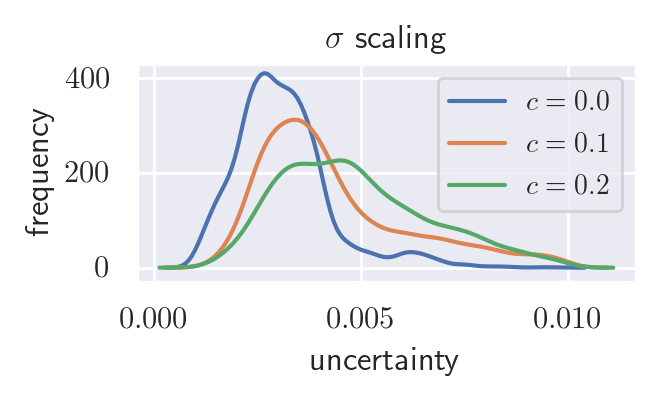

In [413]:
fig, ax = plt.subplots(figsize=(3.3, 2.0))

labels = [r'$c=0.0$', r'$c=0.1$', r'$c=0.2$']

for i in range(3):
    data = uncerts_ood_np[i][np.where(uncerts_ood_np[i] < 0.01)]
    sns.distplot(data, hist_kws={'stacked': True}, kde=True, hist=False, norm_hist=True, label=labels[i], ax=ax)

ax.legend(prop={'size': 10})
ax.set_ylim([-30, 430])
ax.set_xticks([0, 0.005, 0.01])
ax.set_xlabel(r'uncertainty')
ax.set_ylabel(f'frequency')
ax.set_title(f'$ \sigma $ scaling')
fig.tight_layout()
fig.show()
fig.savefig(f"ood_boneage_s_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)